In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from data_preprocesser import preprocessed_data_path

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
df = pd.read_csv(preprocessed_data_path + 'categories_30000/yelp_academic_dataset_review_Auto Repair.csv')
df.head()

,review_id,business_id,stars_x,stars_y,date,city,text,categories
0,JN0tmjiksWfr4i2NIFuPXw,pLZ9oZM8c6MNbRlg06lBPg,1,3.0,2016-08-03,Las Vegas,THEY SELL WRECKED VEHICLES! \nI purchased a 20...,Auto Repair;Car Dealers;Automotive;Auto Parts ...
1,lFmz61DNRzBPnrwH_cF42g,J0KZR0DDnvj73D-xmbh4uA,4,4.0,2017-06-15,Las Vegas,I stopped in here recently as I had to buy a t...,Auto Parts & Supplies;Auto Repair;Automotive
2,R9p3ug8zNPvawYX_jsO0UA,Tknj3u-3CZTI-q52saTAIA,1,1.0,2012-09-12,Toronto,"If you want the ""I don't give a shit "" attitud...",Car Dealers;Auto Repair;Automotive
3,FMXER_6R6URYBpV6TYPn9A,rV1nkTx58v_q7YGDkGzfxQ,5,5.0,2016-06-10,Las Vegas,where to start...\na few months ago I slammed....,Auto Repair;Automotive
4,bJN2ZPa0jF4xgR1gPKZP3A,hCXknMQalY1QQZrdZGuBHg,3,3.5,2017-01-24,Las Vegas,I have mixed feelings here. I recently purchas...,Car Dealers;Auto Repair;Automotive


In [30]:
from textblob import TextBlob

# Processing Functions
def identify_tokens(row):
    review = row['text']
    tokens = nltk.word_tokenize(review)
    # taken only words (not punctuation)
    # token_words = [re.sub("[^\w\s]", " ", w) for w in tokens]
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

stops = set(stopwords.words("english"))                  

def remove_stops(row):
    my_list = row['words']
    meaningful_words = [w for w in my_list if not w in stops and w != " "]
    return (meaningful_words)

tags = ['FW','JJ','JJR','JJS','NN','NNS','NNP','NNPS','RBR','RBS','UH','VB','VBD','VBG','VBN','VBP','VBZ']


stemming = PorterStemmer()

### Garder juste les noms, verbes, adjectifs et interjections

def select_tagged(row):
    my_list = row['words_meaningful']
    tagged_words = nltk.pos_tag(my_list)
    useful_words = [w[0] for w in tagged_words if w[1] in tags]
    return useful_words

### Enlever les mots trops polarisés 

def unpolarized(row):
    my_list = row['useful_words']
    unpolarized_words = [w for w in my_list if (abs(TextBlob(w).sentiment.polarity)<0.2 and abs(TextBlob(w).sentiment.subjectivity)<0.2)]
    return unpolarized_words

stemming = PorterStemmer()

def stem_list(row):
    my_list = row['unpolarized_words']
    stemmed_list = [stemming.stem(word) for word in my_list]
    return (stemmed_list)

lemming = WordNetLemmatizer()

def lem_list(row):
    my_list = row['unpolarized_words']
    lemmed_list = [lemming.lemmatize(word) for word in my_list]
    return (lemmed_list)

def rejoin_words(row):
    my_list = row['stemmed_words']
    joined_words = ( " ".join(my_list))
    return joined_words

In [32]:
def process(data_df):
    data_df['text'] = data_df['text'].str.lower()
    data_df['words'] = data_df.apply(identify_tokens, axis=1)
    data_df['words_meaningful'] = data_df.apply(remove_stops, axis=1)
    data_df['useful_words'] = data_df.apply(select_tagged,axis=1)
    data_df['unpolarized_words'] = data_df.apply(unpolarized,axis=1)
    data_df['lemmed_words'] = data_df.apply(lem_list, axis=1)

    return data_df

In [33]:
df_processed = process(df)

In [34]:
text = " ".join(review for review in df['processed'])
print ("There are {} words in the combination of all review.".format(len(text)))
print(df_processed['processed'].loc[:20])

There are 11664380 words in the combination of all review.
0     sell wrecked vehicles purchased nissan altima ...
1     stopped recently buy torque wrench staff pleas...
2     want give shit attitude service dept staff tak...
3     start months ago truck curb destroyed wheel ri...
4     mixed feelings recently purchased xj one great...
5     start months ago truck curb destroyed wheel ri...
6     last weekend decided go hunt see could find de...
7     difference new location space makes kinda feel...
8     mazda dealership michigan earnhardt never done...
9     review occasionally brought showcase mazda ser...
10    glad found shop put taking miata oil change mo...
11    going town road trip got slow leak one tires h...
12    friendly atmosphere first time offered bottled...
13    gone times different cars time car say x amoun...
14    although planning purchasing bmw anytime soon ...
15    massive store sleepy little town near madison ...
16    love zimbrick acura love every zimbrick

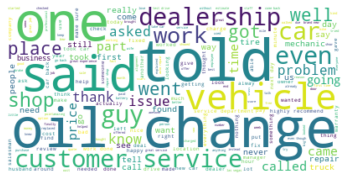

In [17]:
# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# LDA

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = count_vect.fit_transform(df['processed'].values.astype('U'))

doc_term_matrix

<30000x16968 sparse matrix of type '<class 'numpy.int64'>'
	with 1210875 stored elements in Compressed Sparse Row format>

In [18]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=5)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [19]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['manager', 'time', 'price', 'deal', 'new', 'experience', 'vehicle', 'sales', 'dealership', 'car']


Top 10 words for topic #1:
['went', 'said', 'time', 'tires', 'told', 'tire', 'change', 'service', 'car', 'oil']


Top 10 words for topic #2:
['time', 'place', 'friendly', 'customer', 'honest', 'recommend', 'work', 'car', 'great', 'service']


Top 10 words for topic #3:
['thank', 'service', 'thanks', 'guys', 'dealership', 'audi', 'car', 'new', 'jeep', 'great']


Top 10 words for topic #4:
['time', 'problem', 'repair', 'called', 'said', 'took', 'told', 'work', 'shop', 'car']




# NMF

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = tfidf_vect.fit_transform(df['processed'].values.astype('U'))

In [22]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=5)
nmf.fit(doc_term_matrix)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [23]:
for i,topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['sales', 'called', 'went', 'vehicle', 'time', 'new', 'said', 'dealership', 'told', 'car']


Top 10 words for topic #1:
['definitely', 'excellent', 'helpful', 'experience', 'recommend', 'staff', 'friendly', 'customer', 'great', 'service']


Top 10 words for topic #2:
['minutes', 'service', 'hour', 'time', 'changed', 'filter', 'changes', 'appointment', 'change', 'oil']


Top 10 words for topic #3:
['repairs', 'recommend', 'mechanic', 'guys', 'place', 'repair', 'auto', 'honest', 'work', 'shop']


Top 10 words for topic #4:
['went', 'discount', 'needed', 'alignment', 'said', 'told', 'flat', 'new', 'tires', 'tire']




# Gensim LDA

In [7]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

In [8]:
# Create Dictionary
id2word = corpora.Dictionary(df['words_meaningful'])

# Create Corpus
texts = df['words_meaningful']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [30]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('absolutely', 1),
  ('accident', 1),
  ('advise', 1),
  ('altima', 1),
  ('another', 1),
  ('avoid', 1),
  ('began', 1),
  ('bit', 1),
  ('bought', 1),
  ('brakes', 1),
  ('car', 3),
  ('caused', 1),
  ('charged', 1),
  ('clue', 1),
  ('constant', 1),
  ('consumer', 1),
  ('damage', 1),
  ('dealership', 2),
  ('decided', 1),
  ('drove', 1),
  ('every', 1),
  ('except', 1),
  ('exhaust', 1),
  ('finally', 1),
  ('found', 1),
  ('frame', 1),
  ('go', 1),
  ('high', 1),
  ('immediately', 1),
  ('involved', 1),
  ('knowing', 1),
  ('major', 1),
  ('make', 1),
  ('manufacturer', 1),
  ('means', 1),
  ('miles', 1),
  ('months', 2),
  ('much', 1),
  ('nissan', 3),
  ('planet', 2),
  ('pocket', 1),
  ('possible', 1),
  ('powertrain', 1),
  ('prior', 1),
  ('problems', 1),
  ('process', 1),
  ('provided', 1),
  ('purchased', 1),
  ('purchasing', 1),
  ('repairs', 2),
  ('reputable', 1),
  ('savvy', 1),
  ('sell', 1),
  ('selling', 1),
  ('sick', 1),
  ('six', 1),
  ('sold', 1),
  ('someplace

In [31]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [52]:
for (i,topic) in enumerate(lda_model.print_topics()):
    print(f'Top words for topic #{i}:')
    print([i for i in topic[1].split('"') if str(i).isalpha()])
    print('\n')

Top words for topic #0:
['service', 'great', 'work', 'recommend', 'shop', 'always', 'guys', 'honest', 'friendly', 'best']


Top words for topic #1:
['oil', 'change', 'air', 'paint', 'changes', 'filter', 'damage', 'bumper', 'coupon', 'power']


Top words for topic #2:
['told', 'said', 'tire', 'took', 'needed', 'tires', 'problem', 'truck', 'fix', 'new']


Top words for topic #3:
['dealership', 'us', 'vehicle', 'deal', 'sales', 'new', 'experience', 'wanted', 'price', 'buy']


Top words for topic #4:
['car', 'would', 'get', 'back', 'time', 'service', 'one', 'go', 'even', 'could']




In [37]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['words_meaningful'], dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.547943089602035

Coherence Score:  0.4047682781189306


In [57]:
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#vis

# Mallet

In [10]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# You need Java !
mallet_path = '/home/arthur/BNPP_Sentiment_Analysis/mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

In [11]:
for (i,topic) in enumerate(ldamallet.print_topics()):
    print(f'Top words for topic #{i}:')
    print([i for i in topic[1].split('"') if str(i).isalpha()])
    print('\n')

Top words for topic #0:
['service', 'great', 'work', 'recommend', 'place', 'guys', 'customer', 'honest', 'friendly', 'good']


Top words for topic #1:
['oil', 'change', 'car', 'needed', 'shop', 'problem', 'fixed', 'check', 'mechanic', 'fix']


Top words for topic #2:
['car', 'back', 'service', 'time', 'day', 'tire', 'tires', 'called', 'truck', 'hours']


Top words for topic #3:
['told', 'manager', 'call', 'vehicle', 'back', 'give', 'business', 'people', 'asked', 'called']


Top words for topic #4:
['car', 'dealership', 'experience', 'price', 'sales', 'vehicle', 'deal', 'wanted', 'made', 'buy']




In [14]:
coherence_model_lda = CoherenceModel(model=ldamallet, texts=df['words_meaningful'], dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4236716072689492


In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus, 
    texts=df['words_meaningful'], 
    start=2, 
    limit=30, 
    step=5)

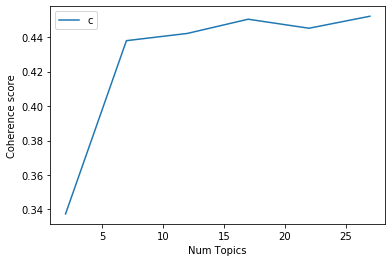

In [18]:
limit=30 
start=2
step=5
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus, 
    texts=df['words_meaningful'], 
    start=3, 
    limit=10, 
    step=2)

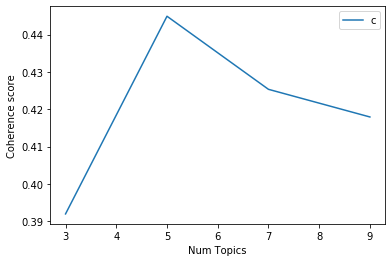

In [20]:
limit=10 
start=3
step=2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Word2Vec

In [9]:
from gensim.models import Word2Vec

In [10]:
model = Word2Vec(df['words_meaningful'], min_count=1, size= 50,workers=3, window=3)

In [20]:
model.most_similar('car')[:10]

/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('vehicle', 0.9262104034423828),
 ('truck', 0.8529120683670044),
 ('cars', 0.6574299931526184),
 ('jeep', 0.6465004682540894),
 ('suv', 0.6396276950836182),
 ('van', 0.6390122771263123),
 ('vehicles', 0.5934978723526001),
 ('yet', 0.5745795965194702),
 ('actually', 0.5659458637237549),
 ('course', 0.5625346899032593)]

In [21]:
X = model[model.wv.vocab]
X.shape

/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(30859, 50)

In [22]:
from sklearn import cluster
from sklearn import metrics

## KMeans

In [23]:
def test_kmeans(num_clusters_max):
    for i in range(2, num_clusters_max):
        print("For " + str(i) + " clusters")
        kmeans = cluster.KMeans(n_clusters=i)
        kmeans.fit(X)
 
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
        
        silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')

        print ("Silhouette_score: ")
        print (silhouette_score)

In [24]:
num_clusters_max = 10
test_kmeans(num_clusters_max)

For 2 clusters
Silhouette_score: 
0.6785999
For 3 clusters
Silhouette_score: 
0.6506184
For 4 clusters
Silhouette_score: 
0.64701355
For 5 clusters
Silhouette_score: 
0.62233645
For 6 clusters
Silhouette_score: 
0.6089072
For 7 clusters
Silhouette_score: 
0.60385716
For 8 clusters
Silhouette_score: 
0.60174984
For 9 clusters
Silhouette_score: 
0.5999154


Keeping 5 clusters :

In [25]:
kmeans = cluster.KMeans(n_clusters=5)
kmeans.fit(X)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [104]:
clusters_list = list(set(labels))
all_words = model.wv.index2word
all_words_meaningful = [item for sublist in df['words_meaningful'].tolist() for item in sublist]
print("TOTAL : {} unique words".format(len(list(set(all_words_meaningful)))))
print("TOTAL : {} meaningful words".format(len(all_words_meaningful)))
print("TOTAL : ratio is {}".format(round(len(list(set(all_words_meaningful)))/len(all_words_meaningful), 5)))

for cluster_id in clusters_list:
    indices = [i for i, x in enumerate(labels) if x == cluster_id]
    print("CLUSTER {} : {} unique words".format(cluster_id, len(indices)))

def visualize_clusters(labels, clusters_blacklist = [0]):   
    clusters_whitelist = [cluster_id for cluster_id in clusters_list if cluster_id not in clusters_blacklist]
    for cluster_id in clusters_whitelist:
        # We want to find the words associated to the cluster
        indices = [i for i, x in enumerate(labels) if x == cluster_id]
        print("CLUSTER {} : {} unique words".format(cluster_id, len(indices)))
        words = [all_words[i] for i in indices]
        words_meaningful = [word for word in all_words_meaningful if word in words]
        
        print("CLUSTER {} : {} meaningful words in the uniques words list".format(cluster_id, len(words_meaningful)))
        print("CLUSTER {} : ratio is {}".format(cluster_id, round(len(indices)/len(words_meaningful), 5)))

        sub_text = " ".join(words_meaningful)
        
        wordcloud = WordCloud(background_color="white").generate(sub_text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

        


TOTAL : 30859 unique words
TOTAL : 1760567 meaningful words
TOTAL : ratio is 0.01753
CLUSTER 0 : 24749 unique words
CLUSTER 1 : 530 unique words
CLUSTER 2 : 514 unique words
CLUSTER 3 : 428 unique words
CLUSTER 4 : 4638 unique words


CLUSTER 1 : 530 unique words
CLUSTER 1 : 555547 meaningful words in the uniques words list
CLUSTER 1 : ratio is 0.00095


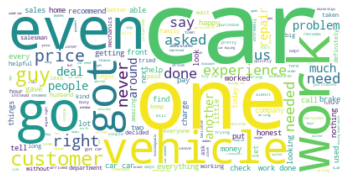

CLUSTER 2 : 514 unique words
CLUSTER 2 : 244022 meaningful words in the uniques words list
CLUSTER 2 : ratio is 0.00211


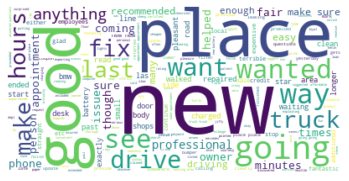

CLUSTER 3 : 428 unique words
CLUSTER 3 : 190927 meaningful words in the uniques words list
CLUSTER 3 : ratio is 0.00224


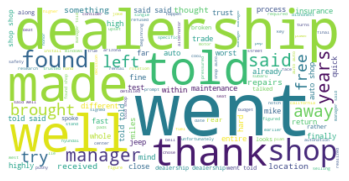

CLUSTER 4 : 4638 unique words
CLUSTER 4 : 580294 meaningful words in the uniques words list
CLUSTER 4 : ratio is 0.00799


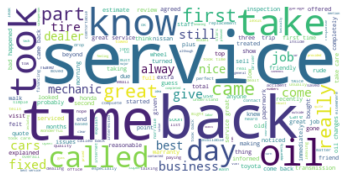

In [105]:
visualize_clusters(labels, [0])

## DBSCAN

In [108]:
dbscan = cluster.DBSCAN(eps=1, min_samples=100)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=100, n_jobs=None, p=None)

In [110]:
labels = dbscan.labels_
clusters_list = list(set(labels))

for cluster_id in clusters_list:
    indices = [i for i, x in enumerate(labels) if x == cluster_id]
    print("CLUSTER {} : {} unique words".format(cluster_id, len(indices)))

CLUSTER 0 : 27666 unique words
CLUSTER -1 : 3193 unique words


In [117]:
dbscan = cluster.DBSCAN(eps=0.1, min_samples=5)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [118]:
labels = dbscan.labels_
clusters_list = list(set(labels))

for cluster_id in clusters_list:
    indices = [i for i, x in enumerate(labels) if x == cluster_id]
    print("CLUSTER {} : {} unique words".format(cluster_id, len(indices)))

CLUSTER 0 : 9972 unique words
CLUSTER 1 : 4 unique words
CLUSTER 2 : 6 unique words
CLUSTER -1 : 20877 unique words


# Glove